In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.special import expit
from tqdm import tqdm

root_dir = "../../"

figure_dir = os.path.join(root_dir, "figures", "sigmoid")
os.makedirs(figure_dir, exist_ok=True)

sns.set_theme()
sns.set_context("paper", font_scale=1.8)

In [2]:
x1_dist = lambda n: norm.rvs(1, 1, size=n)

pos_dist = lambda n: norm.rvs(3, 0.5, size=n)
neg_dist = lambda n: norm.rvs(-1, 1, size=n)
x2_cond = lambda x1: pos_dist(x1.shape[0]) * (x1 >= 3) + neg_dist(x1.shape[0]) * (
    x1 < 3
)

f = lambda x, theta: expit(x @ theta)


def make_data(N, d):
    X = np.empty((N, 2 * d))
    for i in range(d):
        x1 = x1_dist(N)
        x2 = x2_cond(x1)
        X[:, 2 * i] = x1
        X[:, 2 * i + 1] = x2
    return X

In [3]:
N, d = 5000, 3
# change theta_2 to -2 to reproduce figure 2.b
theta = np.array([[1, -2, 1, 1, 1, 1]], dtype=float).T

X = make_data(N, 3)

In [4]:
M, K = 100, 100

p_hat = np.empty((M, N))
for i in tqdm(range(N)):
    x = X[[i], :]

    for j in range(M):
        x_t = np.copy(x)
        x_t[:, 0] = x1_dist(1)

        t = f(x_t, theta)

        x_null = np.copy(x)
        X_null = np.tile(x_null, (K, 1))

        x1_null = x1_dist(K)
        x2_null = x2_cond(x1_null)

        X_null[:, 0] = x1_null
        X_null[:, 1] = x2_null

        t_null = f(X_null, theta)

        _p_hat = (np.sum(t_null >= t) + 1) / (K + 1)

        p_hat[j, i] = _p_hat

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:04<00:00, 77.28it/s]


In [5]:
gamma = np.empty(N)
for i in tqdm(range(N)):
    x = X[[i], :]

    x_t = np.copy(x)
    X_t = np.tile(x_t, (K, 1))

    x1_t = x1_dist(K)

    X_t[:, 0] = x1_t

    t = f(X_t, theta)

    x_null = np.copy(x)
    X_null = np.tile(x_null, (K, 1))

    x1_null = x1_dist(K)
    x2_null = x2_cond(x1_null)

    X_null[:, 0] = x1_null
    X_null[:, 1] = x2_null

    t_null = f(X_null, theta)

    gamma[i] = np.mean(t - t_null)

100%|██████████| 5000/5000 [00:00<00:00, 5972.14it/s]


100it [00:00, 2144.83it/s]


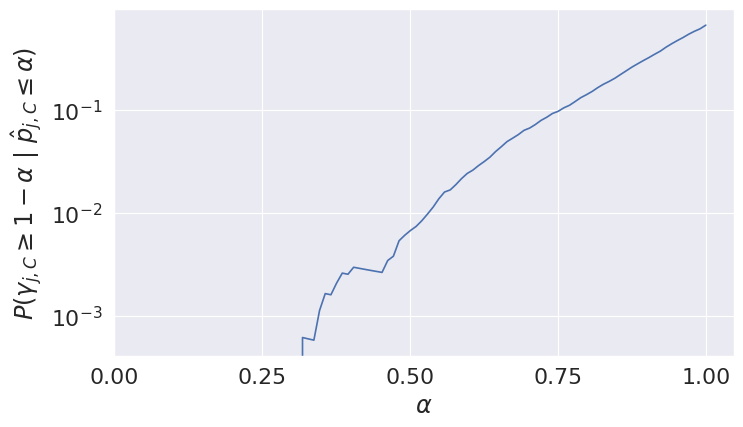

In [6]:
A = 100

aa = np.linspace(0.05, 1, A)

cond_p, gamma_exp = np.empty((M, A)), np.tile(gamma, (M, 1))
for i, a in tqdm(enumerate(aa)):
    cond_p[:, i] = np.sum((gamma_exp >= 1 - a) * (p_hat <= a), axis=1) / np.sum(
        (p_hat <= a), axis=1
    )
mu_cond_p, std_cond_p = np.mean(cond_p, axis=0), np.std(cond_p, axis=0)

_, ax = plt.subplots(figsize=(16 / 2, 9 / 2))
ax.plot(aa, mu_cond_p)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$P(\gamma_{j,C} \geq 1 - \alpha~|~\hat{p}_{j,C} \leq \alpha)$")
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yscale("log")

plt.savefig(os.path.join(figure_dir, "cond_p.pdf"), bbox_inches="tight")
plt.show()